In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
import counterstone as cs

IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
toxdata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/clintox.csv.gz')
#toxdata = toxdata.iloc[:100, :]
toxdata.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [9]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]
raw_features = calc.pandas(valid_mols)
labels = toxdata[valid_mol_idx].FDA_APPROVED

  2%|▏         | 24/1478 [00:02<03:33,  6.80it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  8%|▊         | 120/1478 [00:07<03:36,  6.27it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19%|█▉        | 286/1478 [00:16<04:14,  4.69it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 22%|██▏       | 330/1478 [00:18<04:04,  4.70it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 29%|██▉       | 434/1478 [00:26<04:45,  3.66it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/whit

 33%|███▎      | 493/1478 [00:34<01:16, 12.89it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 34%|███▍      | 500/1478 [00:38<09:33,  1.71it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 37%|███▋      | 552/1478 [00:39<04:37,  3.34it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 39%|███▊      | 571/1478 [00:41<03:13,  4.70it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 50%|█████     | 739/1478 [00:53<03:57,  3.12it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1478/1478 [01:45<00:00, 13.99it/s]


In [10]:
fm = raw_features.mean()
fs = raw_features.std()
def feature_convert(f):
    f -= fm
    f /= fs
    return f

features = feature_convert(raw_features)

# we have some nans in features, likely because std was 0
features = features.values.astype(float)
features_select = np.all(np.isfinite(features), axis=0)
features = features[:, features_select]

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=True)

clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.7155594405594405

In [12]:
eid = 15
example = toxdata.smiles.iloc[valid_mol_idx][eid]
example_y = clf.predict(features[eid:eid+1])

def model_eval(smiles, selfies):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    features = calc.pandas(molecules, quiet=True)
    features = features.values.astype(float)
    features = features[:, features_select]
    labels = clf.predict(features)
    #TODO Enable actual search
    return (example_y - labels).astype(bool)
    #return np.random.choice([True, False], size=labels.shape)
model_eval(['CC', 'CC=O'], [])

array([False, False])

In [13]:
example

'B([C@H](CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)Cl)(O)O'

In [14]:
exps = cs.explain(example, model_eval)

Adjusting max_k to 3
Starting with 1720 explanations


In [15]:
exps

[Explanation(smiles='B([C@H](CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)Cl)(O)O', selfies=None, similarity=1.0, index=None, position=array([0, 0]), is_counter=True, is_base=True),
 Explanation(smiles='CC(C)CC(NC(=O)CNC(=O)c1cc(Cl)ccc1[P+])B(O)O', selfies=None, similarity=0.8208955223880597, index=592, position=array([0.49274472, 0.00524153]), is_counter=False, is_base=False),
 Explanation(smiles='[C+]C(C)CC(NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O', selfies=None, similarity=0.8484848484848485, index=50, position=array([ 0.58086582, -0.02834606]), is_counter=False, is_base=False),
 Explanation(smiles='CC(C)CC(NC(=O)CNC(=O)c1cc(F)ccc1Cl)B(O)O', selfies='', similarity=0.8208955223880597, index=483, position=array([0.49274472, 0.00524153]), is_counter=False, is_base=False),
 Explanation(smiles='CC(C=C=CCl)=CCC(=O)NC(=O)NC(CC(C)C)B(O)O', selfies='', similarity=0.367816091954023, index=1410, position=array([-0.48165342,  0.3719399 ]), is_counter=True, is_base=False),
 Explanation(smiles='CC(NC(=O)NC(CC(C

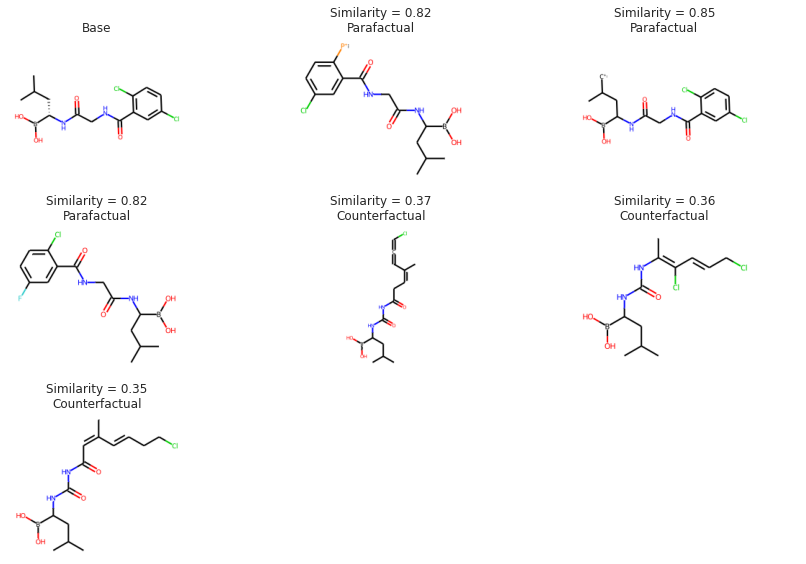

In [16]:
cs.plot_explanation(exps)

In [25]:
from dataclasses import dataclass
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import selfies as sf
from counterstone.stoned.stoned import get_fingerprint
import itertools
import math
from typing import Type
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem.Draw import MolToImage as mol2img
import rdkit.Chem
import adjustText

def trim(im):
    from PIL import Image, ImageChops
    # https://stackoverflow.com/a/10616717
    bg = Image.new(im.mode, im.size, im.getpixel((0, 0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

def plot_explanation(exps, figure_kwargs=None):
    # get aligned images
    ms = [smi2mol(e.smiles) for e in exps]
    rdkit.Chem.AllChem.Compute2DCoords(ms[0])
    for m in ms[1:]:
        rdkit.Chem.AllChem.GenerateDepictionMatching2DStructure(
            m, ms[0], acceptFailure=True)
    # TODO: Make this work someday
    if exps[-1].position is None:
        _grid_plot_explanation(exps, ms, figure_kwargs)
    else:
        _project_plot_explanation(exps, ms, figure_kwargs)


def _project_plot_explanation(exps, mols, figure_kwargs=None, mol_size=(200, 200)):
    import matplotlib.pyplot as plt
    if figure_kwargs is None:
        figure_kwargs = {'figsize': (12, 8)}
    plt.figure(**figure_kwargs)
    imgs = [mol2img(m, size=mol_size) for m in mols]
    clabel = False
    plabel = False
    for i, e in enumerate(exps[1:]):
        if e.is_counter:
            plt.plot([exps[0].position[0], e.position[0]], [exps[0].position[1], e.position[1]],
                     marker='o', color='C0', label='Counterfactual' if not clabel else None)
            clabel = True
        else:
            plt.plot([exps[0].position[0], e.position[0]], [exps[0].position[1], e.position[1]],
                     marker='o', color='C1', label='Parafactual' if not plabel else None)
            plabel = True
    plt.gca().set_facecolor('white')
    plt.axis('off')
    plt.gca().set_aspect('equal')
    x = [e.position[0] for e in exps]
    y = [e.position[1] for e in exps]
    titles = []
    colors = []
    for e in exps:
        if not e.is_base:
            titles.append(f'Similarity = {e.similarity:.2f}')
            colors.append('C0' if e.is_counter else 'C1')
        else:
            titles.append('Base')
            colors.append('C2')
    adjustText.adjust_text(_image_scatter(x, y, imgs, titles, colors, plt.gca()))
    plt.legend()


def _image_scatter(x, y, imgs, subtitles, colors, ax):
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, VPacker

    ax.scatter(x, y)
    bbs = []
    for x0, y0, i, t, c in zip(x, y, imgs, subtitles, colors):
        # add transparency
        i = trim(i)
        img_data = np.asarray(i)
        img_box = OffsetImage(img_data)
        title_box = TextArea(t)
        packed = VPacker(children=[img_box, title_box],
                         pad=0, sep=4, align='center')
        bb = AnnotationBbox(
            packed, (x0, y0),
            alpha=0.0, frameon=True,
            bboxprops=dict(edgecolor=c))
        ax.add_artist(bb)
        bbs.append(bb)
    return bbs


def _grid_plot_explanation(exps, mols, figure_kwargs=None):
    import matplotlib.pyplot as plt
    imgs = [mol2img(m, size=(250, 200)) for m in mols]
    if figure_kwargs is None:
        figure_kwargs = {'figsize': (12, 8)}
    C = math.ceil(math.sqrt(len(imgs)))
    R = math.ceil(len(imgs) / C)
    fig, axs = plt.subplots(R, C, **figure_kwargs)
    axs = axs.flatten()
    for i, (img, e) in enumerate(zip(imgs, exps)):
        title = 'Base' if e.is_base else f'Similarity = {e.similarity:.2f}'
        if not e.is_base:
            title += '\nCounterfactual' if e.is_counter else '\nParafactual'
        axs[i].set_title(title)
        axs[i].imshow(np.asarray(img))
        axs[i].axis('off')
    for j in range(i, C * R):
        axs[j].axis('off')
        axs[j].set_facecolor('white')
    plt.tight_layout()


AttributeError: 'AnnotationBbox' object has no attribute 'get_position'

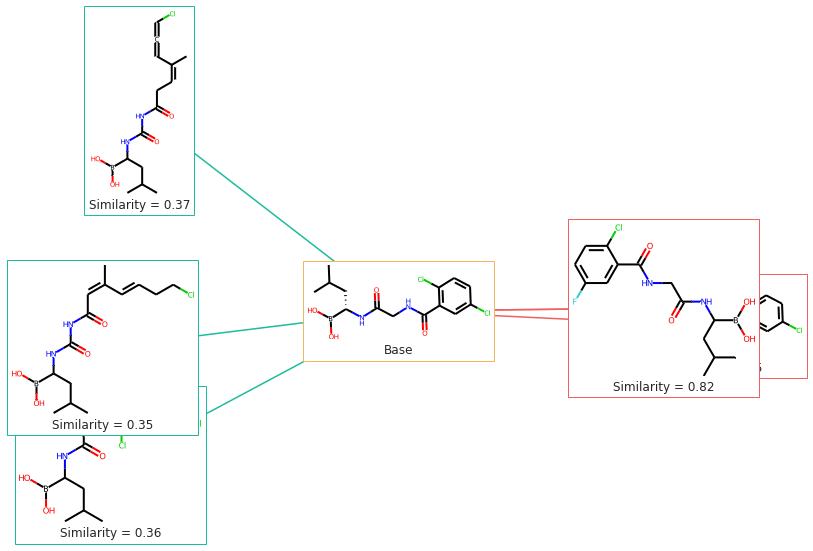

In [26]:
plot_explanation(exps)

In [ ]:
[e.position for e in exps]